# User-based Collaborative Filtering

In [1]:
import pandas as pd
import gzip
import json
from math import sqrt
from scipy.stats import pearsonr
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

## Load in ratings data

In [2]:
df = pd.read_csv(r'./ratings_data/Software.csv',names = ['asin','reviewerID','overall','timestamp'])
#Only keep 3 columns
df = df[['overall', 'asin', 'reviewerID']].sort_values('reviewerID')
df.head()

,overall,asin,reviewerID
350131,5.0,B01617VNBK,A00577669P2XCLU956L8
262198,5.0,B00MCLGAZ4,A00621707WIM8QF2CT5O
301851,5.0,B00SX73LIK,A0065811S4ANKB4TYHII
428464,4.0,B007A7JSMM,A0086201G57OY58MG97W
360077,4.0,B019QVZDSC,A0086201G57OY58MG97W


## Introduce input User with ratings on products

In [3]:
#use a user's ratings (below is an example)
userInput = [
            {'asin':'B00UB76290', 'overall':5},
            {'asin':'B00CTTEKJW', 'overall':3.5},
            {'asin':'B00NG7JVSQ', 'overall':2},
            {'asin':'B00MCLGAZ4', 'overall': 4},
            {'asin':'B00H9A60O4', 'overall': 4},
            {'asin':'B00U1UELFE', 'overall': 1},
            {'asin':'B00D9ILKGS', 'overall': 4.5},
            {'asin':'B019QVZDSC', 'overall': 2},
         ]

inputItems = pd.DataFrame(userInput)
inputItems

,asin,overall
0,B00UB76290,5.0
1,B00CTTEKJW,3.5
2,B00NG7JVSQ,2.0
3,B00MCLGAZ4,4.0
4,B00H9A60O4,4.0
5,B00U1UELFE,1.0
6,B00D9ILKGS,4.5
7,B019QVZDSC,2.0


## Filter out ratings data to only include ratings of products reviewed by our input User

In [4]:
#Filtering out users that have rated products that the input has rated and storing it
userSubset = df[df['asin'].isin(inputItems['asin'].tolist())]
userSubset.head()

,overall,asin,reviewerID
262198,5.0,B00MCLGAZ4,A00621707WIM8QF2CT5O
360077,4.0,B019QVZDSC,A0086201G57OY58MG97W
239111,5.0,B00H9A60O4,A0101607BMUAQ65AR9LL
303244,2.0,B00U1UELFE,A01344607GRFTG6SU5L6
436173,1.0,B00D9ILKGS,A0135824JBPU8ADCLM59


## Group ratings by users, and compare (using correlation) to our input User

## Compute similarity index

In [5]:
#Group ratings dataset by user
grouped = userSubset.groupby('reviewerID')
grouped = sorted(grouped,  key=lambda x: len(x[1]), reverse=True)
#only keep first 1000 as this is sequential algo
grouped = grouped[0:1000]

In [6]:
#get pearson corr when comparing user's ratings with our input user
pearsonCorrelationList = []
inputItems = inputItems.sort_values(by='asin')

#group contains items a user has rated
for user, group in grouped:
    group = group.sort_values(by='asin')
    nRatings = len(group)

    temp_df = inputItems[inputItems['asin'].isin(group['asin'].tolist())]
    nSimilarItems = len(temp_df)
    tempRatingList = temp_df['overall'].tolist()
    tempGroupList = group['overall'].tolist()
    
    if nRatings > 1:
        try:
            #r = calc_corr(tempRatingList, tempGroupList, nRatings)
            r = pearsonr(tempRatingList, tempGroupList)[0]
            pearsonCorrelationList.append([user, r, nSimilarItems])
        except:
            pearsonCorrelationList.append([user, 0, -1])

pearson_df = pd.DataFrame(pearsonCorrelationList, columns=['reviewerID', 'similarityIndex', 'nSimilarItems'])

## Create Weighted rating of potential items using similarity index and rating from users

In [7]:
#get top users (closest to our users)
top_users=pearson_df.loc[(pearson_df.nSimilarItems>=3) & (pearson_df.similarityIndex.notna())].sort_values(by='similarityIndex', ascending=False)[0:50]
top_users.head()

,reviewerID,similarityIndex,nSimilarItems
1,A1MH90R0ADMIK0,1.000000,3
3,AZDH08P9ZMWKJ,0.755929,3
0,A11KZ906QD08C5,0.188982,3


In [8]:
#get other items that top users have rated
topUsersRating=top_users.merge(df, on='reviewerID', how='inner')
#create weightedRating
topUsersRating['weightedRating'] = topUsersRating['similarityIndex']*topUsersRating['overall']
recommendation_df = topUsersRating.groupby('asin').sum()[['similarityIndex','weightedRating']]
recommendation_df.columns = ['sum_similarityIndex','sum_weightedRating']
recommendation_df['weighted average recommendation score'] = recommendation_df['sum_weightedRating']/recommendation_df['sum_similarityIndex']
recommendation_df = recommendation_df.sort_values(by=['weighted average recommendation score', 'sum_similarityIndex'], ascending=[False, False])
recommendation_df.head()

,sum_similarityIndex,sum_weightedRating,weighted average recommendation score
asin,,,
B00UB76290,1.944911,9.724556,5.0
B0144BWWTW,1.000000,5.000000,5.0
B00009APNB,0.188982,0.944911,5.0
B000A9QUT6,0.188982,0.944911,5.0
B000HCVR3A,0.188982,0.944911,5.0


(array([10.,  0.,  0.,  0.,  0.,  0.,  0.,  5.,  0.,  0.,  0.,  0.,  0.,
         0.,  5.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  7.,  0.,  0.,  0.,
         0.,  0.,  0., 12.]),
 array([1.        , 1.13333333, 1.26666667, 1.4       , 1.53333333,
        1.66666667, 1.8       , 1.93333333, 2.06666667, 2.2       ,
        2.33333333, 2.46666667, 2.6       , 2.73333333, 2.86666667,
        3.        , 3.13333333, 3.26666667, 3.4       , 3.53333333,
        3.66666667, 3.8       , 3.93333333, 4.06666667, 4.2       ,
        4.33333333, 4.46666667, 4.6       , 4.73333333, 4.86666667,
        5.        ]),
 <a list of 30 Patch objects>)

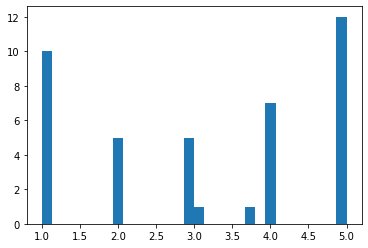

In [9]:
plt.hist(recommendation_df['weighted average recommendation score'], bins=30)